# Predicting Next-Day Stock Price Direction in the S&P 500

In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

from xgboost import XGBClassifier

DATA_PATH = "https://raw.githubusercontent.com/tabbott207/3156Final/refs/heads/main/data/all_stocks_5yr.csv"

RANDOM_STATE = 42

plt.style.use("seaborn-v0_8")

In [39]:
# Load the CSV
df = pd.read_csv(DATA_PATH)

print("Columns:", df.columns.tolist())
print("Number of rows:", len(df))

# Convert date to datetime and sort
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["Name", "date"]).reset_index(drop=True)

df.head()

Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'Name']
Number of rows: 619040


,date,open,high,low,close,volume,Name
0,2013-02-08,45.07,45.35,45.00,45.08,1824755,A
1,2013-02-11,45.17,45.18,44.45,44.60,2915405,A
2,2013-02-12,44.81,44.95,44.50,44.62,2373731,A
3,2013-02-13,44.81,45.24,44.68,44.75,2052338,A
4,2013-02-14,44.72,44.78,44.36,44.58,3826245,A


 Basic Data Exploration

In [40]:
print("Date range:", df["date"].min(), "to", df["date"].max())
print("\nSample of tickers:", df["Name"].unique()[:10])

print("\nSummary of closing prices:")
print(df["close"].describe())

print("\nSummary of volume:")
print(df["volume"].describe())

Date range: 2013-02-08 00:00:00 to 2018-02-07 00:00:00

Sample of tickers: ['A' 'AAL' 'AAP' 'AAPL' 'ABBV' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADI']

Summary of closing prices:
count    619040.000000
mean         83.043763
std          97.389748
min           1.590000
25%          40.245000
50%          62.620000
75%          94.410000
max        2049.000000
Name: close, dtype: float64

Summary of volume:
count    6.190400e+05
mean     4.321823e+06
std      8.693610e+06
min      0.000000e+00
25%      1.070320e+06
50%      2.082094e+06
75%      4.284509e+06
max      6.182376e+08
Name: volume, dtype: float64


Visualize Stock Price

Sample ticker: A


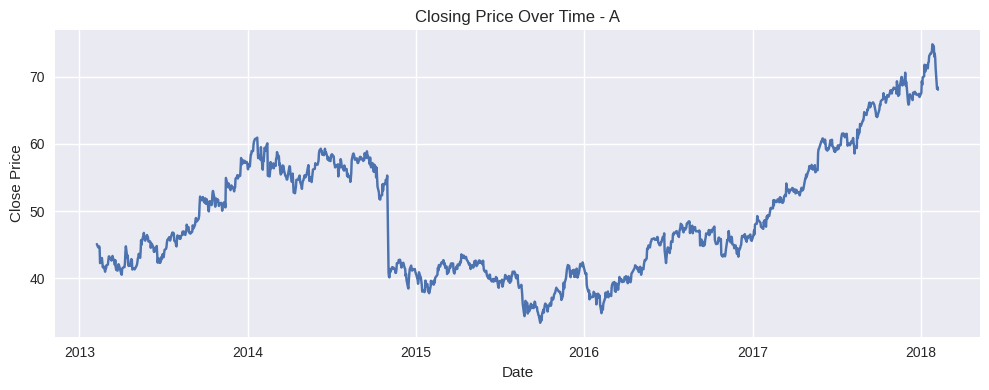

In [41]:
sample_ticker = df["Name"].unique()[0]
print("Sample ticker:", sample_ticker)

sample_df = df[df["Name"] == sample_ticker]

plt.figure(figsize=(10, 4))
plt.plot(sample_df["date"], sample_df["close"])
plt.title(f"Closing Price Over Time - {sample_ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.tight_layout()
plt.show()

count    618535.000000
mean          0.000541
std           0.016060
min          -0.626183
25%          -0.006793
50%           0.000635
75%           0.008105
max           1.009513
Name: return_1d, dtype: float64


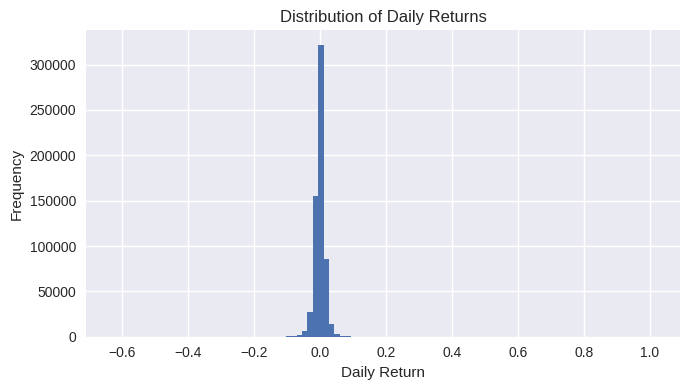

In [42]:
df["close_prev"] = df.groupby("Name")["close"].shift(1)
df["return_1d"] = (df["close"] - df["close_prev"]) / df["close_prev"]

print(df["return_1d"].describe())

plt.figure(figsize=(7, 4))
df["return_1d"].hist(bins=100)
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Feature Engineering

In [43]:
df_feat = df.copy()

# Previous day close and daily return (already computed above, but recompute cleanly)
df_feat["close_prev"] = df_feat.groupby("Name")["close"].shift(1)
df_feat["return_1d"] = (df_feat["close"] - df_feat["close_prev"]) / df_feat["close_prev"]

# Intraday range
df_feat["range_pct"] = (df_feat["high"] - df_feat["low"]) / df_feat["close"].replace(0, np.nan)

# Rolling features within each stock
grouped_close = df_feat.groupby("Name")["close"]
grouped_vol = df_feat.groupby("Name")["volume"]
grouped_ret = df_feat.groupby("Name")["return_1d"]

df_feat["roll5_mean_close"] = grouped_close.transform(lambda s: s.rolling(window=5, min_periods=5).mean())
df_feat["roll5_std_close"] = grouped_close.transform(lambda s: s.rolling(window=5, min_periods=5).std())
df_feat["roll10_mean_vol"] = grouped_vol.transform(lambda s: s.rolling(window=10, min_periods=10).mean())
df_feat["roll5_mean_ret"] = grouped_ret.transform(lambda s: s.rolling(window=5, min_periods=5).mean())

# Next-day close and target label
df_feat["close_next"] = df_feat.groupby("Name")["close"].shift(-1)
df_feat["target_up"] = (df_feat["close_next"] > df_feat["close"]).astype(int)

# Drop rows with missing values from shifts and rolling windows
df_feat = df_feat.dropna().reset_index(drop=True)

print("Rows after feature engineering:", len(df_feat))

# Check class balance
print("\nClass balance (fraction of samples):")
print(df_feat["target_up"].value_counts(normalize=True))

Rows after feature engineering: 613983

Class balance (fraction of samples):
target_up
1    0.521413
0    0.478587
Name: proportion, dtype: float64


Train–Test Split

In [44]:
# Feature columns
feature_cols = [
    "open",
    "high",
    "low",
    "close",
    "volume",
    "return_1d",
    "range_pct",
    "roll5_mean_close",
    "roll5_std_close",
    "roll10_mean_vol",
    "roll5_mean_ret",
]

# Choose a cutoff date for train/test split
cutoff_date = "2017-01-01"
cutoff = pd.to_datetime(cutoff_date)

train_mask = df_feat["date"] < cutoff
test_mask = df_feat["date"] >= cutoff

df_train = df_feat[train_mask].copy()
df_test = df_feat[test_mask].copy()

X_train = df_train[feature_cols].values
y_train = df_train["target_up"].values

X_test = df_test[feature_cols].values
y_test = df_test["target_up"].values

print("Cutoff date:", cutoff_date)
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])
print("Number of features:", len(feature_cols))

Cutoff date: 2017-01-01
Train size: 475380
Test size: 138603
Number of features: 11


Model Evaluation Function

In [45]:
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}\n")

    print("Classification report:")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, cmap="Blues")
    plt.colorbar()
    plt.xticks([0, 1], ["Down/Flat", "Up"])
    plt.yticks([0, 1], ["Down/Flat", "Up"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {name}")

    # Annotate counts
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()

Random Forest Model


=== Random Forest ===
Accuracy : 0.5196
Precision: 0.5316
Recall   : 0.7472
F1-score : 0.6212

Classification report:
              precision    recall  f1-score   support

           0     0.4851    0.2657    0.3434     65525
           1     0.5316    0.7472    0.6212     73078

    accuracy                         0.5196    138603
   macro avg     0.5084    0.5064    0.4823    138603
weighted avg     0.5096    0.5196    0.4898    138603



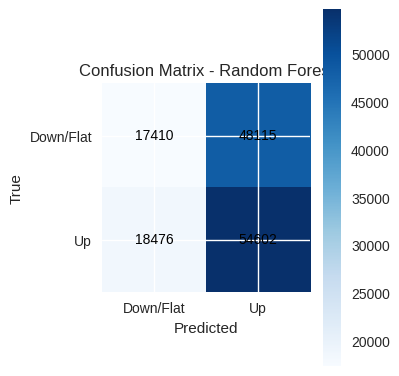

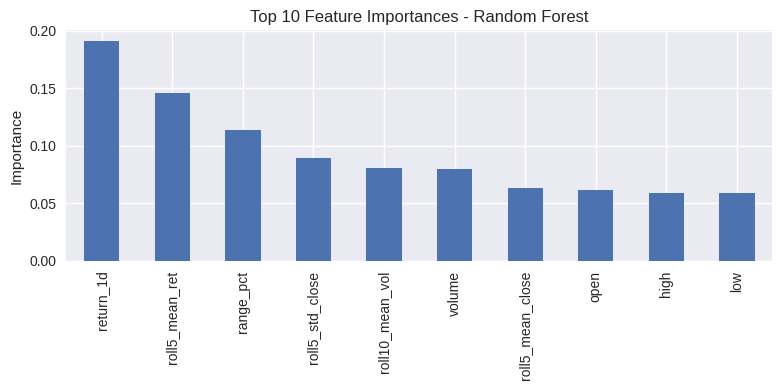

,0
return_1d,0.190663
roll5_mean_ret,0.145839
range_pct,0.113969
roll5_std_close,0.089241
roll10_mean_vol,0.081084
volume,0.079617
roll5_mean_close,0.063151
open,0.061348
high,0.058761
low,0.058665


In [46]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    max_samples=0.5,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

evaluate_model("Random Forest", y_test, y_pred_rf)

rf_importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
rf_importances.head(10).plot(kind="bar")
plt.title("Top 10 Feature Importances - Random Forest")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

rf_importances

XGBoost Model


=== XGBoost ===
Accuracy : 0.5200
Precision: 0.5336
Recall   : 0.7112
F1-score : 0.6097

Classification report:
              precision    recall  f1-score   support

           0     0.4878    0.3066    0.3766     65525
           1     0.5336    0.7112    0.6097     73078

    accuracy                         0.5200    138603
   macro avg     0.5107    0.5089    0.4931    138603
weighted avg     0.5119    0.5200    0.4995    138603



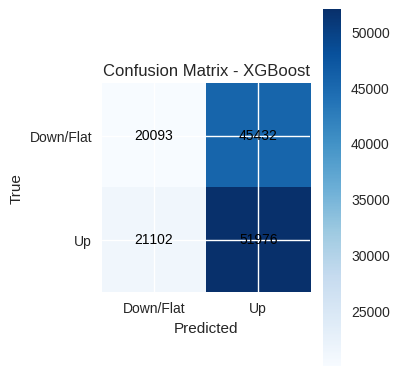

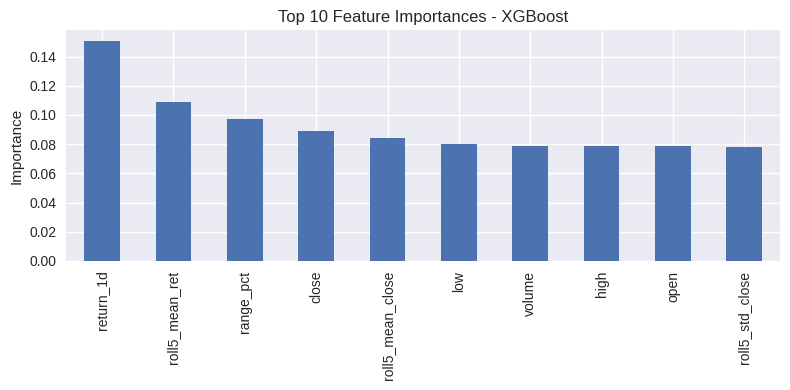

,0
return_1d,0.150426
roll5_mean_ret,0.109001
range_pct,0.097368
close,0.088930
roll5_mean_close,0.084007
low,0.080403
volume,0.078791
high,0.078696
open,0.078467
roll5_std_close,0.078122


In [47]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

evaluate_model("XGBoost", y_test, y_pred_xgb)

# Feature importance plot
xgb_importances = pd.Series(xgb.feature_importances_, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
xgb_importances.head(10).plot(kind="bar")
plt.title("Top 10 Feature Importances - XGBoost")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

xgb_importances

 Comparison of Models

In [48]:
metrics = []

def collect_metrics(name, y_true, y_pred):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

metrics.append(collect_metrics("Random Forest", y_test, y_pred_rf))
metrics.append(collect_metrics("XGBoost", y_test, y_pred_xgb))

metrics_df = pd.DataFrame(metrics)
metrics_df

,model,accuracy,precision,recall,f1
0,Random Forest,0.519556,0.531577,0.747174,0.621201
1,XGBoost,0.519967,0.533591,0.711240,0.609739
